# Сравнение классификаторов

Суть задания состоит в том, чтобы сравнить различные классификаторы на наборе данных Extended MNIST https://www.nist.gov/itl/products-and-services/emnist-dataset. <br>
Набор одержит монохромные изображения латинских букв. <br>
На каждом изображении содержится по одной букве в низком разрешении (28 на 28 пикселей). <br>
<br>
Нужно использовать 88,800 изображений для обучения и 14,800 изображений, чтобы проверить качество классификации. <br>
При тестировании следует применить различные модели, включая (но не ограничиваясь): <br>
-- KNeighborsClassifier <br>
-- LogisticRegression <br>
-- Naive Bayes <br>
-- Bayesian Classifier <br>
-- Linear SVC <br>
-- DecisionTreeClassifier <br>
<br>
В этой части требуется провести эксперименты с различными моделями и гиперпараметрами моделей. <br>
Оценить качество классификаторов и сравнить их друг с другом по различным метрикам (не только по основной метрике соревнования).<br>
<br>
Попробуйте уменьшить размерность пространства при помощи PCA (или других аналогичных) методов и сравнить результаты до и после уменьшения размерности.<br>

## Подготовка данных

### Чтение файлов csv

In [1]:
# Распаковка zip с датасетами (для работы с github, файлы больше 100мб требуют git lfs, но он почему-то не захотел работать)
import shutil
shutil.unpack_archive("emnist-letters.zip")

In [2]:
# Функция для преобразования csv в numpy
import pandas as pd
import numpy as np

def loadCsv(path):
    # Load train data
    X = pd.read_csv(path, header=None)

    # separate column w/ predicts
    y = pd.DataFrame(X[0])
    y.columns=['Y']
    y = y.to_numpy().T[0]

    X = X.drop(columns={0})
    X = X.to_numpy()
    return [X, y]

In [3]:
# Load exam data
X_exam = pd.read_csv('emnist-letters-exam.csv', index_col=0)
X_exam = X_exam.to_numpy()

# Load train & test data
X_train, y_train = loadCsv('emnist-letters-train.csv')
X_test, y_test = loadCsv('emnist-letters-test.csv')

### Выводим изображения букв

In [4]:
import matplotlib.pyplot as plt

In [5]:
# Функция для вывода буквы на ось из линейного массива
def printLetter(ax, pic28x28, title = ""):
    pic28x28 = np.array(pic28x28).reshape((28,28))
    ax.imshow(pic28x28, cmap='gist_gray')
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    if len(title) != 0:
        ax.set_title(title)

In [6]:
# Функция для вывода 52 случайных букв из массива Х
def printSomeLetters(X):
    lettersPrintList = [0, 1]
    fig, axes = plt.subplots(4, 13, figsize=(20, 7))
    for yUnique in np.unique(y_trainFull):
        for i in lettersPrintList:
            ax = axes.ravel()[i + len(lettersPrintList) * (yUnique-1)]
            printLetter(ax, X[ np.random.randint( len(X) ) ])

#### Выводим изображения букв и набора для обучения

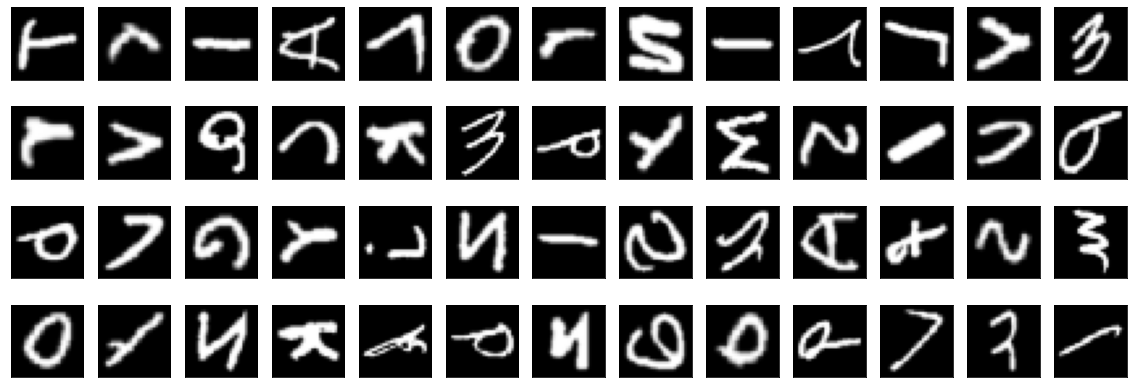

In [7]:
printSomeLetters(X_train)

In [ ]:
printSomeLetters(X_test)

##### Буквы выглядят повернутыми, транспонируем матрицы изображений

In [7]:
for i, X in enumerate(X_train):
    X_train[i] = np.array(X).reshape((28, 28)).T.ravel()
for i, X in enumerate(X_test):
    X_test[i] = np.array(X).reshape((28, 28)).T.ravel()

##### Повторно выводим буквы из набора для обучения

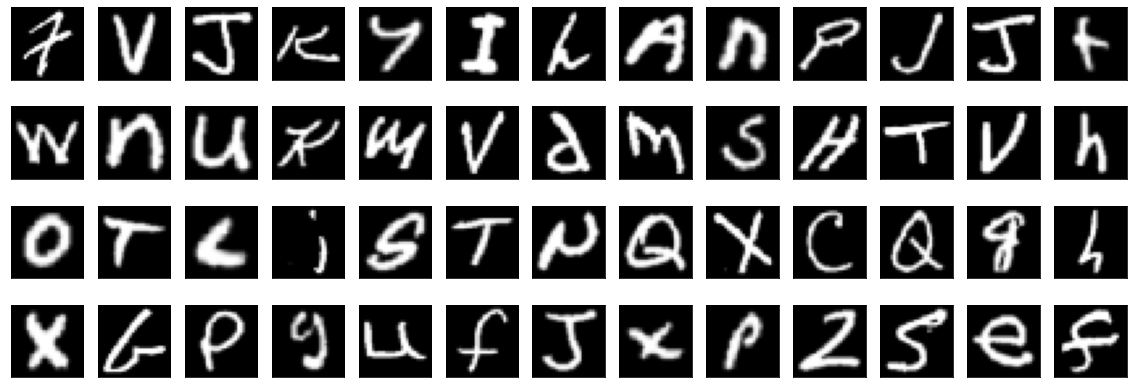

In [18]:
printSomeLetters(X_train)

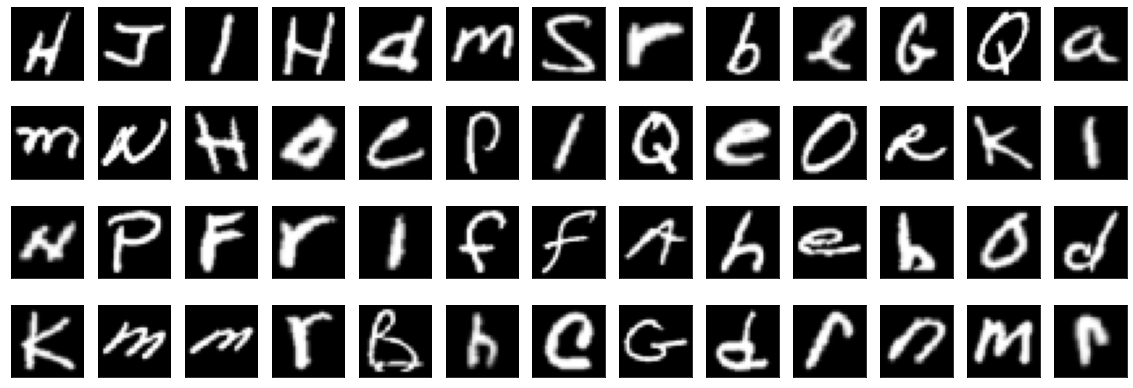

In [19]:
printSomeLetters(X_test)

#### Выводим изображения букв и набора для проверки

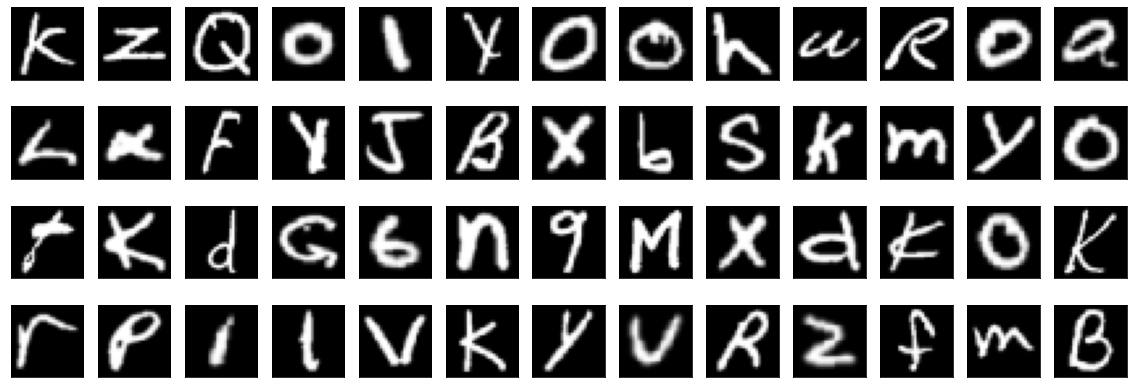

In [20]:
printSomeLetters(X_exam)

### Utility Functions

In [8]:
# Функция для построения непрерывный график по точкам
# ax - ось, для отображения графика
# data - точки, Y  

def PlotScoreGraph(ax, colorName, dataY, dataX = []):
        dataY = np.array(dataY)
        nData = len(dataY)
        if dataX == []:
                dataX = np.arange(1,nData + 1) # соответсвие каждому Y и его индексу если X пуст

        ax.plot(
                dataY, 
                marker='o',
                color=colorName
                )

        dataMin, dataMax = np.min(dataY), np.max(dataY)

        ax.grid(True)
        minScale, maxScale = 0.95, 1.05 
        ax.set_yticks(np.linspace(dataMin * minScale, dataMax * maxScale, 10))
        ax.set_xticks(dataX - 1)
        ax.set_xticklabels(dataX)

        ax.set_ylim(dataMin * minScale, dataMax * maxScale)
        ax.set_xlim(-1, nData)

        ax.tick_params(
                axis = 'both', 
                which = 'major',
                direction = 'inout',
                bottom = False,
                top = False,
                left = False,
                right = False
                )

In [9]:
# Функция для получения времени обучения, времени работы, предикта
from timeit import default_timer as dtimer

def GetModelPrediction(classifier, X_train, y_train, X_test):
    start_time = dtimer()
    classifier.fit(X_train, y_train)
    timeToFit = dtimer() - start_time
    
    start_time = dtimer()
    predict = classifier.predict(X_test)
    timeToPredict = dtimer() - start_time

    return [timeToFit, timeToPredict, predict]

In [10]:
# Функция для расчета графика зависимости размера тренировочной выборки на точность
def PlotTrainingCurve(classifierInit, X_trainIn, y_trainIn, X_testIn, y_testIn):
    _TrainingSize = np.linspace(10, len(y_trainIn), 12, dtype=np.int32)
    scoreTest = []
    scoreTrain = []
    for _size in _TrainingSize:
        classifier = classifierInit
        X_trainPart = X_trainIn[:_size]
        y_trainPart = y_trainIn[:_size]
        classifier.fit(X_train, y_train)
        scoreTest.append(classifier.score(X_testIn, y_testIn))
        scoreTrain.append(classifier.score(X_trainPart, y_trainPart))

    fig, ax = plt.subplots(figsize=(6, 7))
    ax.plot(_TrainingSize, scoreTrain, marker='o', color='blue')
    ax.plot(_TrainingSize, scoreTest, marker='o', color='green')
    ax.legend(["Train", "Test"],loc=1)
    ax.set(title="Training Set Size to Score",
            xlabel="Size",
            ylabel="Score")
    ax.set_xticks(_TrainingSize)

In [11]:
# Функция для получения статистических метрик из предсказания
from sklearn import metrics

def calcMetrics(y_predict, y_true):
    return [metrics.accuracy_score(y_true, y_predict),
            metrics.precision_score(y_true, y_predict, average='weighted', zero_division=0),
            metrics.recall_score(y_true, y_predict, average='weighted', zero_division=0),
            metrics.f1_score(y_true, y_predict, average='weighted', zero_division=0)]


In [57]:
class MetricsPack:
    def __init__(self):
        self.timeToFit  = []
        self.timeToPredict  = []
        self.accuracy  = []
        self.precision  = []
        self.recall  = []
        self.f1  = []
        self.predictions = []
    def Add(self, timeToFit, timeToPredict, predict, metricVals):
        self.timeToFit.append(timeToFit)
        self.timeToPredict.append(timeToPredict)
        self.predictions.append(predict)
        self.accuracy.append(metricVals[0])
        self.precision.append(metricVals[1])
        self.recall.append(metricVals[2])
        self.f1.append(metricVals[3])
    def GetTimeToFit(self):
        return [self.timeToFit, "Time to Fit"]
    def GetTimeToPredict(self):
        return [self.timeToPredict, "Time to Predict"]
    def GetAccuracy(self):
        return [self.accuracy, "Accuracy Score"]
    def GetPrecision(self):
        return [self.precision, "Precision Score"]
    def GetRecall(self):
        return [self.recall, "Recall Score"]
    def GetF1(self):
        return [self.f1, "F1 Score"]

## Уменьшение размерности. PCA.

In [23]:
from sklearn.decomposition import PCA 

In [24]:
pca = PCA().fit(X_train)

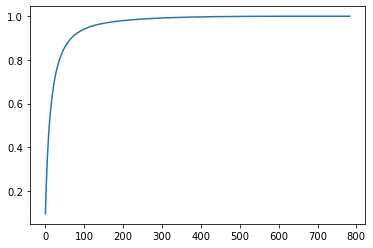

In [25]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [26]:
print("Размер, при котором точность увеличивается менее чем на 10**-4: ", 
    sizePCA:=np.where(pca.explained_variance_ratio_ < 10**-4)[0][0])

Размер, при котором точность увеличивается менее чем на 10**-4:  268


In [27]:
pca = PCA(n_components=sizePCA).fit(X_train)

In [28]:
X_exam_pca = pca.transform(X_exam)

In [29]:
X_train_pca = pca.transform(X_train)

In [30]:
X_test_pca = pca.transform(X_test)

## Сравнение моделей

In [ ]:
# Функция для построения графиков метрик
def plotMetric(ax, dataPack, fn):
    ax.set_title(fn(dataPack[0])[1])
    PlotScoreGraph(ax, 'red', fn(dataPack[0])[0])
    PlotScoreGraph(ax, 'blue', fn(dataPack[1])[0])
    ax.legend(["Original", "PCA("+str(sizePCA)+")"])

def plot6Metrics(packOrig:MetricsPack, packPCA:MetricsPack):
    fg, ax = plt.subplots(2, 3, figsize=(18, 7))
    ax = ax.ravel()
    packs = [packOrig, packPCA]
    plotMetric(ax[0], packs, MetricsPack.GetTimeToFit)
    plotMetric(ax[1], packs, MetricsPack.GetTimeToPredict)
    plotMetric(ax[2], packs, MetricsPack.GetAccuracy)
    plotMetric(ax[3], packs, MetricsPack.GetPrecision)
    plotMetric(ax[4], packs, MetricsPack.GetRecall)
    plotMetric(ax[5], packs, MetricsPack.GetF1)

In [51]:
def scoreModel(classifier, metricPack:MetricsPack):
    timeToFit, timeToPredict, predict = GetModelPrediction(classifier, X_train, y_train, X_test)
    metricPack.Add(timeToFit, timeToPredict, predict, calcMetrics(predict, y_test))

### KNeighborsClassifier

In [50]:
from sklearn.neighbors import KNeighborsClassifier as KNeighborsClassifier

n_neighborsRange = list(range(1, 16))

In [45]:
metricsKNN = MetricsPack()
metricsKNN_PCA = MetricsPack()
for k in n_neighborsRange:
    scoreModel(KNeighborsClassifier(n_neighbors = k), metricsKNN)
    scoreModel(KNeighborsClassifier(n_neighbors = k), metricsKNN_PCA)

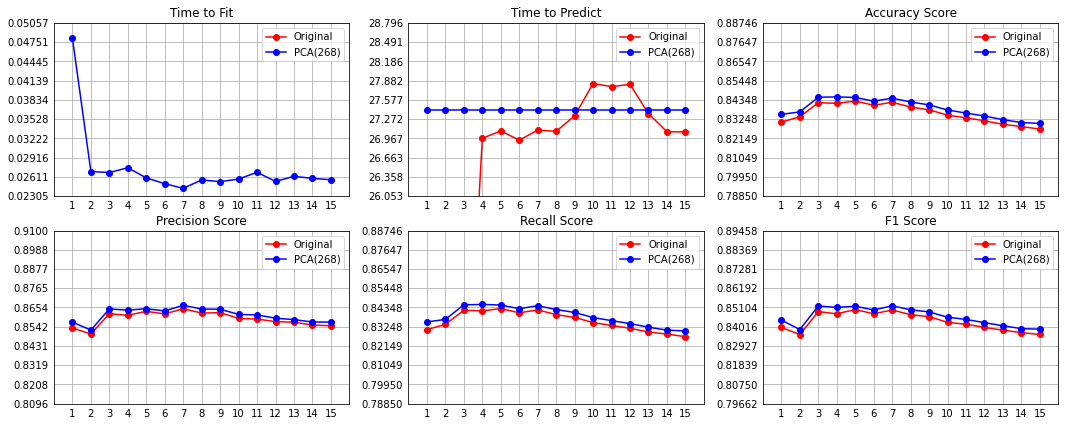

In [49]:
plot6Metrics(metricsKNN, metricsKNN_PCA)

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 3)
PlotTrainingCurve(classifier, X_train, y_train, X_test, y_test)

## LogisticRegression

In [54]:
from sklearn.linear_model import LogisticRegression as LogisticRegression

max_iterRange = np.linspace(10, 100, 3)

In [55]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

metricsLR = MetricsPack()
metricsLR_PCA = MetricsPack()
for k in max_iterRange:
    log_regression = Pipeline(
        [("scale", preprocessing.StandardScaler()), 
        ("log_reg", LogisticRegression(max_iter=k, solver='saga')),]
    )

    scoreModel(log_regression, metricsLR)
    scoreModel(log_regression, metricsLR_PCA)


c:\Users\leysh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\leysh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

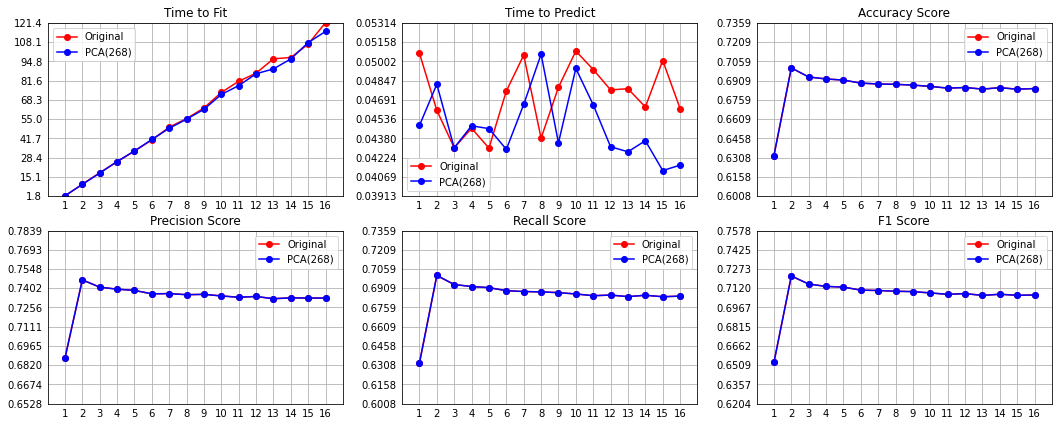

In [58]:
plot6Metrics(metricsLR, metricsLR_PCA)

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB as NaiveBayes

In [ ]:
scoresNB, timesFitrNB, timesScorerNB = [], [], []
for k in list(range(1, 16)):
    classifier = NaiveBayes()

    timeToFit, timeToScore, score = GetModelPrediction(classifier=classifier)

    timesFitrNB.append(timeToFit)
    timesScorerNB.append(timeToScore)
    scoresNB.append(score)

In [ ]:
print(timesFitrNB)
print(timesScorerNB)
print(scoresNB)

In [ ]:
fg, ax = plt.subplots(1, 3, figsize=(18, 7))
PlotScoreGraph(ax[0], timesFitrNB)
PlotScoreGraph(ax[1], timesScorerNB)
PlotScoreGraph(ax[2], scoresNB)


## Bayesian Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB as BayesianClassifier

In [ ]:
scoresrBC, timesFitrBC, timesScorerBC = [], [], []
for smoothing in np.linspace(0, 1, 10):
    classifier = BayesianClassifier(alpha=smoothing)

    score, timeToFit, timeToScore = GetModelPrediction(classifier=classifier)

    timesFitrBC.append(timeToFit)
    timesScorerBC.append(timeToScore)
    scoresrBC.append(score)

In [ ]:
print(timesFitrBC)
print(timesScorerBC)
print(scoresrBC)

In [ ]:
fg, ax = plt.subplots(1, 3, figsize=(18, 7))
PlotScoreGraph(ax[0], timesFitrBC)
PlotScoreGraph(ax[1], timesScorerBC)
PlotScoreGraph(ax[2], scoresrBC)

## Linear SVC

In [ ]:
from sklearn.svm import LinearSVC as LinearSVC

In [ ]:
scoresrSVC, timesFitrSVC, timesScorerSVC = [], [], []
for k in list(range(1, 16)):
    classifier = LinearSVC()
    
    score, timeToFit, timeToScore = GetModelPrediction(classifier=classifier)

    timesFitrSVC.append(timeToFit)
    timesScorerSVC.append(timeToScore)
    scoresrSVC.append(score)

In [ ]:
print(scoresrSVC)
print(timesFitrSVC)
print(timesScorerSVC)

In [ ]:
fg, ax = plt.subplots(1, 3, figsize=(18, 7))
PlotScoreGraph(ax[0], scoresrSVC)
PlotScoreGraph(ax[1], timesFitrSVC)
PlotScoreGraph(ax[2], timesScorerSVC)

## DecisionTreeClassifier

In [71]:
from sklearn.tree import DecisionTreeClassifier as DecisionTreeClassifier

In [72]:
scoresDTC, timesFitDTC, timesScoreDTC = [], [], []
for k in list(range(1, 16)):
    classifier = DecisionTreeClassifier(max_depth=k)
    
    timeToFit, timeToScore, score = GetModelPrediction(classifier=classifier)

    timesFitDTC.append(timeToFit)
    timesScoreDTC.append(timeToScore)
    scoresDTC.append(score)

In [73]:
print(scoresDTC)
print(timesFitDTC)
print(timesScoreDTC)

[0.7614140999994561, 1.3807049999995797, 2.0622364999999263, 2.8325462000002517, 3.716931900000418, 4.660593499999777, 5.67472589999943, 6.76698099999976, 7.986493899999914, 9.299540200000592, 10.477533600000243, 11.618919399999868, 12.654040200000054, 13.514877399999932, 14.257309699999496]
[0.053543099999842525, 0.047840500000347674, 0.05241939999996248, 0.0495506999995996, 0.049707000000125845, 0.04972120000002178, 0.05199209999955201, 0.05028160000074422, 0.053545499999927415, 0.052197500000147556, 0.05475340000066353, 0.05429619999995339, 0.05691050000041287, 0.05502450000039971, 0.05539339999995718]
[0.07409722222222222, 0.12399305555555555, 0.20857638888888888, 0.30875, 0.41184027777777776, 0.46569444444444447, 0.51375, 0.5671875, 0.6044791666666667, 0.6402430555555556, 0.6593055555555556, 0.6714236111111112, 0.6736458333333334, 0.6762152777777778, 0.6763888888888889]


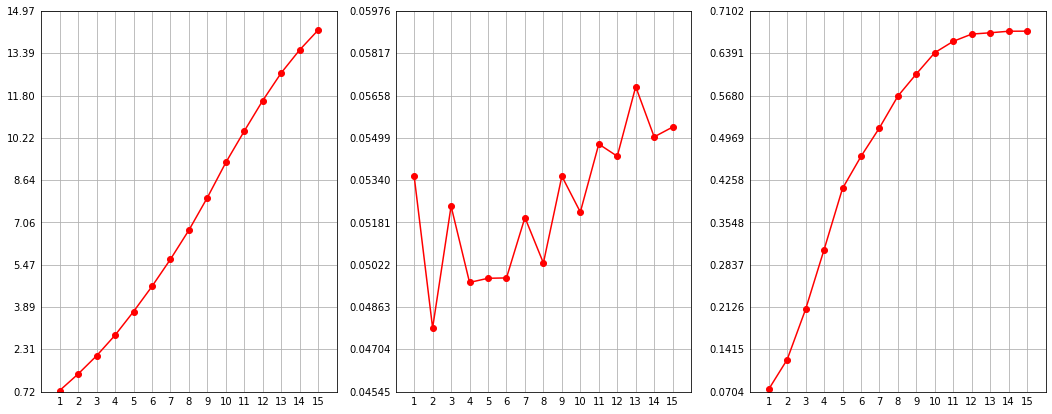

In [74]:
fg, ax = plt.subplots(1, 3, figsize=(18, 7))
PlotScoreGraph(ax[0], timesFitDTC)
PlotScoreGraph(ax[1], timesScoreDTC)
PlotScoreGraph(ax[2], scoresDTC)


## RandomForestClassifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
scoresRFC, timesFitRFC, timesScoreRFC = [], [], []
for k in list(range(1, 16)):
    classifier = RandomForestClassifier()

    timeToFit, timeToScore, score = GetModelPrediction(classifier=classifier)

    timesFitRFC.append(timeToFit)
    timesScoreRFC.append(timeToScore)
    scoresRFC.append(score)

In [20]:
print(timesFitRFC)
print(timesScoreRFC)
print(scoresRFC)

[48.36965579999969, 46.86212609999984, 46.9232834999998, 48.669824399999925, 53.042806700000256, 52.36426759999995, 53.02098380000007, 52.09997340000018, 52.39198189999979, 52.663464900000236, 52.9044957000001, 52.8849624999998, 53.01992770000015, 52.397230500000205, 52.09082559999979]
[1.2105028000000857, 1.3126631999998608, 1.2054692000001523, 1.5110147000000325, 1.5071248999997806, 1.4494168999999602, 1.4791086000000178, 1.4256368999999722, 1.4831710000003113, 1.477545199999895, 1.4379580999998325, 1.469105000000127, 1.4137688999999227, 1.4586349999999584, 1.3915049000002]
[0.8679861111111111, 0.8670138888888889, 0.8669097222222222, 0.8684027777777777, 0.8680555555555556, 0.8692708333333333, 0.8684722222222222, 0.8680902777777778, 0.8680902777777778, 0.8678472222222222, 0.8679861111111111, 0.8681597222222223, 0.8676736111111111, 0.8672916666666667, 0.8681597222222223]


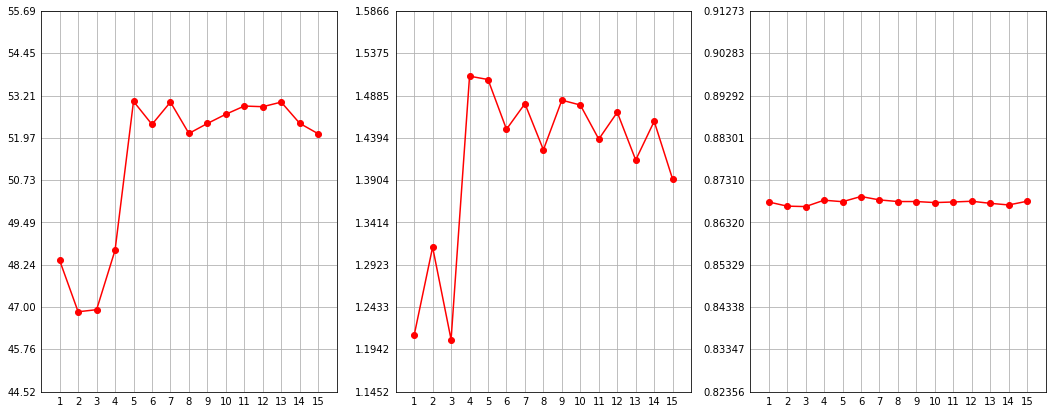

In [21]:
fg, ax = plt.subplots(1, 3, figsize=(18, 7))
PlotScoreGraph(ax[0], timesFitRFC)
PlotScoreGraph(ax[1], timesScoreRFC)
PlotScoreGraph(ax[2], scoresRFC)